In [3]:
import numpy as np 
import matplotlib.pyplot as plt
from numpy import random
import statistics
import os

from slab import get_next_filename, AttrDict


Could not load InstrumentManagerWindow
Could not import QickSoc: No module named 'pynq'
Could not import QickInstrument, try install qick package
Could not load labbrick
Could not load Autonics TM4 Driver


In [27]:
import yaml
# Results config file:
results_config_file = 'autocalibration_cfg.yml'
results_config_path = os.getcwd() + '\\' + results_config_file
print('Results config will be', results_config_path)

# open the file 
with open(results_config_file,'r') as file:
  auto_cfg=AttrDict(yaml.safe_load(file)) # turn it into an attribute dictionary 

Results config will be c:\_Lib\python\rfsoc\elaine_rfsoc\slab_rfsoc_expts\autocalibration_cfg.yml


Import the data: 

In [41]:
x_data = np.linspace(0, 10000, 10000)
y_data = 20*random.rand(10000)

qubit_i =  0 
total_pulse_time = 4*auto_cfg.device.qubit.pulses.pi_ge.sigma[qubit_i] + auto_cfg.device.qubit.T1[qubit_i] + auto_cfg.device.readout.readout_length[qubit_i] + auto_cfg.device.readout.relax_delay[qubit_i]
print(total_pulse_time, 'us')

time_data = x_data*total_pulse_time
print(time_data)

191.6201928060095 us
[0.00000000e+00 1.91639357e+02 3.83278713e+02 ... 1.91581865e+06
 1.91601029e+06 1.91620193e+06]


In [42]:
qubit_i =  0 
total_pulse_time = 4*auto_cfg.device.qubit.pulses.pi_ge.sigma[qubit_i] + auto_cfg.device.qubit.T1[qubit_i] + auto_cfg.device.readout.readout_length[qubit_i] + auto_cfg.device.readout.relax_delay[qubit_i]
print(total_pulse_time, 'us')

In [39]:
import csv

results = []
with open("t1_raw_i3.csv") as csvfile:
    reader = csv.reader(csvfile, quoting=csv.QUOTE_NONNUMERIC)
    for row in reader:
        results.extend(row)

# Convert the results list to a NumPy array if needed
import numpy as np
result_array = np.array([results])
print(np.shape(result_array))
x_data = np.arange(result_array.size)
plt.scatter(x_data, result_array, s = 0.1)

Histogram the data

Text(0, 0.5, 'Amplitude')

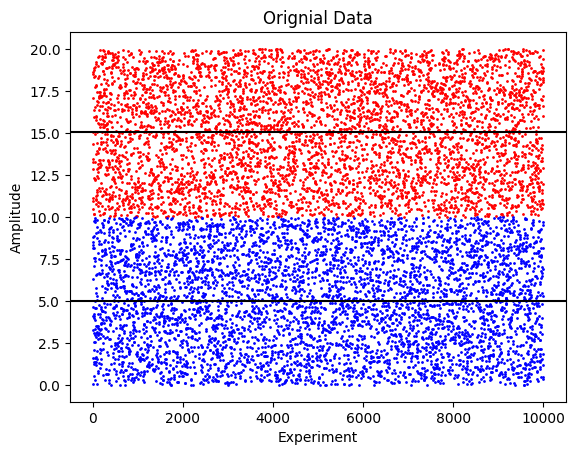

In [16]:
ge_threshold = 10
y_data_e = [] 
y_data_g = [] 
x_data_e = []
x_data_g = []

for i in range(len(y_data)):
    if y_data[i] >= ge_threshold:
        y_data_e.append(y_data[i])
        x_data_e.append(x_data[i])
    else:
        y_data_g.append(y_data[i])
        x_data_g.append(x_data[i])

# Convert the lists to NumPy arrays if needed
y_data_e = np.array(y_data_e)
y_data_g = np.array(y_data_g)

e_avg = np.average(y_data_e)
g_avg = np.average(y_data_g)

std_deve = statistics.stdev(y_data_e)
std_devg = statistics.stdev(y_data_g) 
# Create weighted arrays using Gaussian function
gaussian_weight_e = np.exp(-(y_data_e - e_avg)**2 / (2 * std_deve**2))
gaussian_weight_g = np.exp(-(y_data_g - g_avg)**2 / (2 * std_devg**2))

# Apply Gaussian weighting to the data
e_data_weighted = (y_data_e * gaussian_weight_e)
e_data_weighted = (y_data_e * gaussian_weight_e)/np.max(e_data_weighted)

g_data_weighted = (y_data_g * gaussian_weight_g)
g_data_weighted = (y_data_g * gaussian_weight_g)/np.max(g_data_weighted)

plt.scatter(x_data_e, y_data_e, color = 'red', label = 'e', s = 1)
plt.scatter(x_data_g, y_data_g, color = 'blue', label = 'g', s = 1)
plt.axhline(y=e_avg, color='black', linestyle='-', label = 'avg of e state')
plt.axhline(y=g_avg, color='black', linestyle='-', label = 'avg of g state')
plt.title('Orignial Data')
plt.xlabel('Experiment')
plt.ylabel('Amplitude')


Hanning on the original data

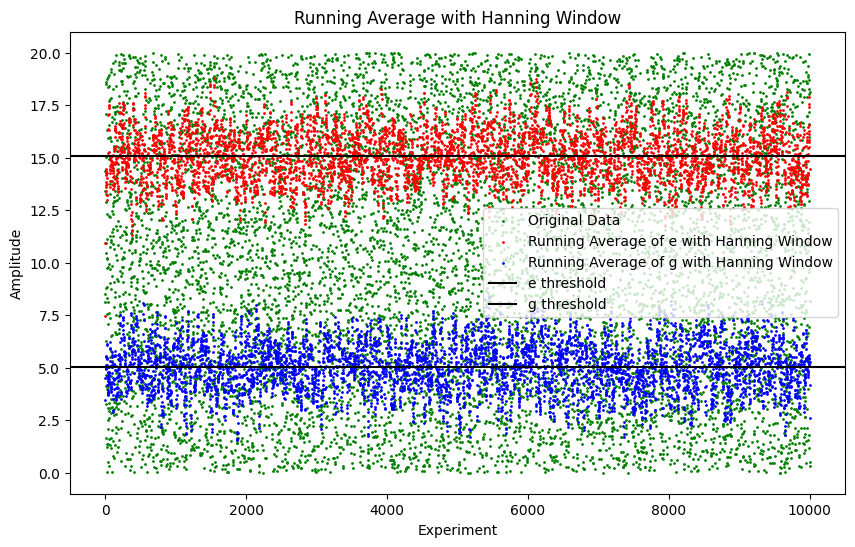

In [17]:
window_size = 10
hanning_window = np.hanning(window_size) / np.sum(np.hanning(window_size))  # Normalize the window

# Apply running average using convolution
y_data_smoothed_e = np.convolve(y_data_e, hanning_window, mode='same')
y_data_smoothed_g = np.convolve(y_data_g, hanning_window, mode = 'same')
# Plot the original and smoothed data
plt.figure(figsize=(10, 6))
plt.scatter(x_data, y_data, label='Original Data', color = 'green', s = 1)
plt.scatter(x_data_e, y_data_smoothed_e, label='Running Average of e with Hanning Window', color = 'red', s = 1)
plt.scatter(x_data_g, y_data_smoothed_g, label='Running Average of g with Hanning Window', color = 'blue', s =1)
plt.axhline(y=e_avg, color='black', linestyle='-', label = 'e threshold')
plt.axhline(y=g_avg, color='black', linestyle='-', label = 'g threshold')
plt.title('Running Average with Hanning Window')
plt.xlabel('Experiment')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

Hanning on the histogramed data

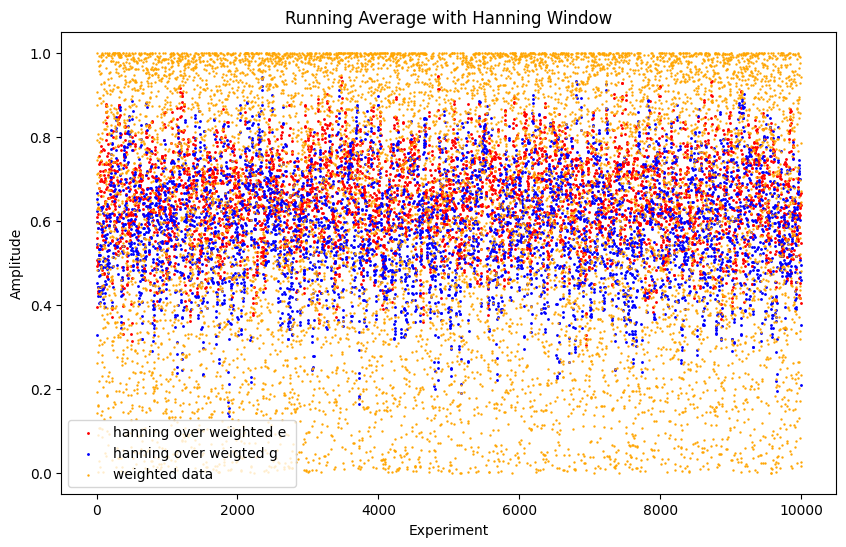

In [20]:
window_size = 10
hanning_window = np.hanning(window_size) / np.sum(np.hanning(window_size))  # Normalize the window

# Apply running average using convolution
y_data_smoothed_e = np.convolve(e_data_weighted, hanning_window, mode='same')
y_data_smoothed_g = np.convolve(g_data_weighted, hanning_window, mode = 'same')
# Plot the original and smoothed data
plt.figure(figsize=(10, 6))
plt.scatter(x_data_e, y_data_smoothed_e, label='hanning over weighted e ', color = 'red', s = 1.1)
plt.scatter(x_data_g, y_data_smoothed_g, label='hanning over weigted g', color = 'blue', s =1.1)
plt.scatter(x_data_e, e_data_weighted, color = 'orange', label = 'weighted data', s = 0.5 )
plt.scatter(x_data_g, g_data_weighted, color = 'orange', s =0.5 )

plt.title('Running Average with Hanning Window')
plt.xlabel('Experiment')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

In [90]:
import csv

# List to store the rows
all_rows = []
results = []
with open("t1_i_03.csv") as csvfile:
    reader = csv.reader(csvfile, quoting=csv.QUOTE_NONNUMERIC)
    for column in reader:
        # Append each row to the list
        all_rows.append(row)

print('Downloaded the CSV.')


Downloaded the CSV.


In [107]:
import numpy as np

# Read data from CSV file
data = np.loadtxt('t1_q03.csv')

# Print the loaded data
# print(data)

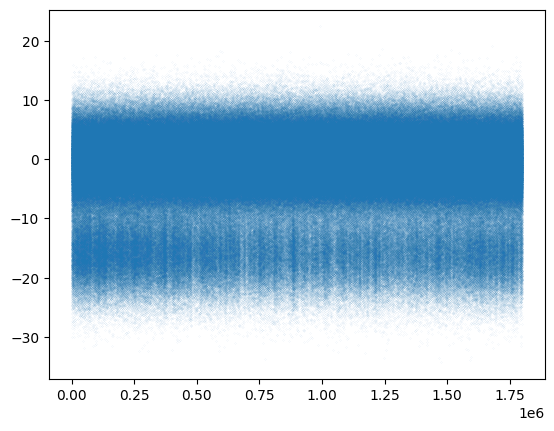

In [108]:
plt.plot(data, '.', markersize=0.05)

In [104]:
pulse_time = (4*0.05889005791993152 + 211.8234892547973 + 15.0 + 2000.0)*1e-6 # in seconds

In [106]:
print(len(data)*pulse_time/3600)

0.5567647623716192


In [63]:
print(np.size(all_rows[2]))

20000


In [64]:
print(np.size(all_rows[3]))

40000


In [53]:
print(np.size(all_rows[4]))

0


In [75]:
plt.plot(t1_cont.data['raw_i'])

NameError: name 't1_cont' is not defined

In [54]:
print(np.size(all_rows[5]))

IndexError: list index out of range

In [1]:
import h5py


In [2]:
with h5py.File('2024-02-09_13-00-17.h5', 'r') as f:
    d1 = f['array_1']
    d2 = f['array_2']

OSError: Unable to open file (bad object header version number)

In [7]:
import numpy as np 

In [19]:
filename = "C:\_Data\LLqub_contT1\data.h5"
hf = h5py.File(filename, 'r')


In [20]:

filename = "C:\_Data\LLqub_contT1\data.h5"
hf = h5py.File(filename, 'r')

# Initialize dictionaries to store datasets
datasets_t1_cont = {}
datasets_t1_recal = {}

# Loop through each group and store datasets in dictionaries
for group_name in hf.keys():
    group = hf[group_name]
    datasets_group = {}
    for dataset_name in group.keys():
        datasets_group[dataset_name] = np.array(group[dataset_name])
    if group_name == 't1_cont':
        datasets_t1_cont = datasets_group
    elif group_name == 't1_recal':
        datasets_t1_recal = datasets_group

# Close the HDF5 file
hf.close()

C:\Users\slab\AppData\Local\Temp\ipykernel_4144\2642946530.py:13: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  datasets_group[dataset_name] = np.array(group[dataset_name])


In [21]:
print(datasets_t1_cont.keys())

dict_keys(['amp', 'i', 'q'])


In [23]:
print(np.shape(datasets_t1_cont['amp']))

(108000000,)
